In [14]:
import torch
from torchvision import datasets, transforms, utils
import torch.nn as nn
import torch.optim as optim
import os
import argparse
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math
from models.vgg import vgg11, vgg16, vgg19
from models.resnet import resnet50
from utils import prepare_data, load_data, CIFAR_100_TRANSFORM_TRAIN, CIFAR_100_TRANSFORM_TEST, CIFAR_10_TRANSFORM, load_imageFolder_data
from classifier import train, eval
from saliency.fullgrad import FullGrad
from saliency.simple_fullgrad import SimpleFullGrad
from misc_functions import save_saliency_map, NormalizeInverse
from racial_accuracies import racial_acc
from racial_test import compute_save_fullgrad_saliency

In [15]:
load_model = 'saved-models/RESNET50-4-best.pth' # set to empty string if model needs to be trained
train_directory = 'dataset/extra_experiment/train'
test_directory = 'dataset/extra_experiment/test'
save_path = 'results/'
device = torch.device('cuda:0')
batch_size = 128
num_workers = 2
learning_rate= 0.1

transform = transforms.Compose(
    [transforms.Resize((64,64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

unnormalize = NormalizeInverse(mean = [0.5, 0.5, 0.5],
                    std = [0.5, 0.5, 0.5])

model = resnet50(num_classes=2).to(device)

In [16]:

dataset = datasets.ImageFolder(root=train_directory, transform=transform)
trainloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)

dataset = datasets.ImageFolder(root=test_directory, transform=transform)
testloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, num_workers=num_workers)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, nesterov=True, weight_decay=5e-4)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[60, 120, 160, 200], gamma=0.2)

In [17]:
if load_model:
    model.load_state_dict(torch.load(load_model), True if device == 'cuda' else False)
else:
    train(model, criterion, optimizer, scheduler, trainloader, testloader, device,
        'saved-models/', 'RESNET50', 1, epochs=10)
    

In [18]:
fullgrad = FullGrad(model, im_size=(1,3,64,64))
simple_fullgrad = SimpleFullGrad(model)

dataset = datasets.ImageFolder(root='dataset/saliency/', transform=transform)
saliencyloader = torch.utils.data.DataLoader(dataset, batch_size=1, num_workers=num_workers)

compute_save_fullgrad_saliency(saliencyloader, unnormalize, save_path, device, fullgrad)

racial_acc(testloader, model, optimizer, criterion, device)


Completeness test passed for FullGrad.
Male, lighter, accuracy : 0.9507772020725389
Male, darker, accuracy : 0.7075471698113207
Female, lighter, accuracy : 0.976271186440678
Female, darker, accuracy : 0.8228782287822878


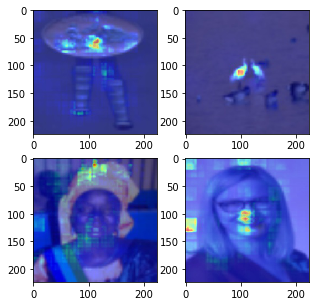

In [19]:
fix_shape = math.ceil(math.sqrt(len(os.listdir(save_path))))
fig=plt.figure(figsize=(5, 5))

for i, name in enumerate(os.listdir(save_path)):
    image = mpimg.imread(save_path + '/' + name)
    fig.add_subplot(fix_shape, fix_shape, i+1)
    plt.imshow(image, interpolation='nearest')
plt.show()